In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-06-11 19:42:45--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-06-11 19:42:45 (24.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Read the text file
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(f"Length of dataset in characters: {len(text)}")
print(text[:500])  # Preview the first 500 characters

Length of dataset in characters: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [4]:
unique_chars = sorted(set(text))
vocab_size = len(unique_chars)
indexes = list(range(len(unique_chars)))
char_to_int = dict(zip(unique_chars, indexes))
int_to_char = dict(zip(indexes, unique_chars))

def encode(x):
    return [char_to_int[c] for c in x]

def decode(x):
    return ''.join([int_to_char[i] for i in x])

data = torch.tensor(encode(text), dtype=torch.long)

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [5]:
block_size = 128
batch_size = 32
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
learning_rate = 3e-4
max_iters = 5000
eval_interval = 500
eval_iters = 200

In [6]:
def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [8]:
model = GPTLanguageModel()
model = model.to(device)
print(f"Model has {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Model has 10.74M parameters


In [11]:
# Initialize lists to store losses and iteration numbers
train_losses = []
val_losses = []
eval_steps = []

# Training loop
for iter in range(max_iters):
    # Every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Store the losses and iteration number
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        eval_steps.append(iter)

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # Show progress every 50 steps
    if iter % 50 == 0:
        print(f"step {iter}: loss {loss.item():.4f}")

step 0: train loss 1.8843, val loss 1.9778
step 0: loss 1.9720
step 50: loss 1.8598
step 100: loss 1.9214
step 150: loss 1.8705
step 200: loss 1.7567
step 250: loss 1.7984
step 300: loss 1.8096
step 350: loss 1.7718
step 400: loss 1.7374
step 450: loss 1.6978
step 500: train loss 1.6328, val loss 1.7960
step 500: loss 1.6737
step 550: loss 1.7087
step 600: loss 1.6324
step 650: loss 1.6616
step 700: loss 1.6175
step 750: loss 1.6742
step 800: loss 1.5726
step 850: loss 1.6033
step 900: loss 1.5925
step 950: loss 1.5946
step 1000: train loss 1.5059, val loss 1.6981
step 1000: loss 1.5690
step 1050: loss 1.5810
step 1100: loss 1.5830
step 1150: loss 1.5897
step 1200: loss 1.4968
step 1250: loss 1.5189
step 1300: loss 1.4855
step 1350: loss 1.5288
step 1400: loss 1.5454
step 1450: loss 1.5022
step 1500: train loss 1.4347, val loss 1.6309
step 1500: loss 1.4872
step 1550: loss 1.5010
step 1600: loss 1.4765
step 1650: loss 1.5460
step 1700: loss 1.4807
step 1750: loss 1.4929
step 1800: loss

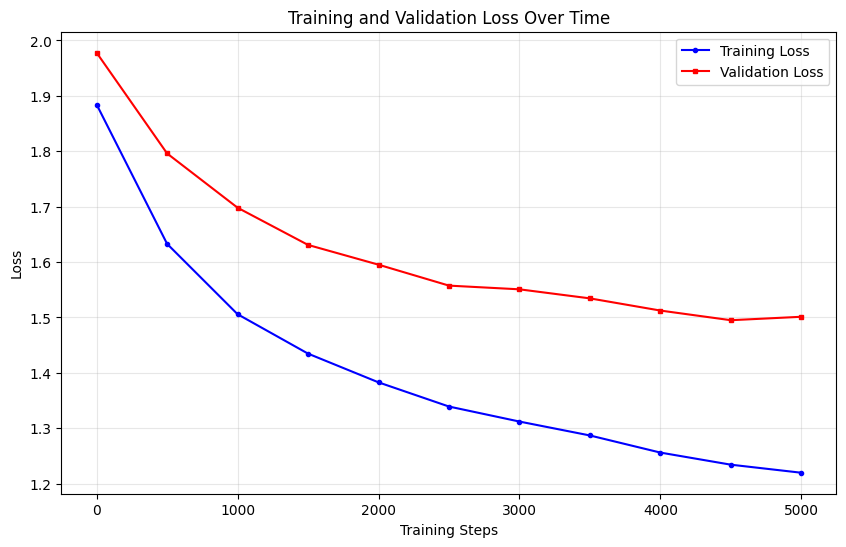

In [13]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, train_losses, label='Training Loss', color='blue', marker='o', markersize=3)
plt.plot(eval_steps, val_losses, label='Validation Loss', color='red', marker='s', markersize=3)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(generated_text)


The Kore honour.

KING RICHARD III:
Neither is another.

QUEEN ELIZABETH:
Here's sociatpy counts, boy a fellow is marriage,
Make proaching in the friends, corrow right,
Which trives this, it best, gallest, die,
Wields look you that in Podribe,
This constrant, and yet hath goft spell pastient
Give glor to this restoren of a child;
That old and a loss of thrivant blood,
To let himmean our courses did with Romeon?

LARD KENTIO:
What, be it dicken and did store a love from Friar life,
His pomiciance
